### Imports and function definitions

In [2]:
#This directory contains all the data needed for the module. It should be in the same directory as the notebook
dataFolder = "data" 
import sys, os, shutil, errno, string, urllib


sys.path.append(( os.path.abspath( os.path.join(os.path.realpath("__file__"),  os.pardir, os.pardir) )))
import uvmodlib.v1 as uvmod

In [5]:
# Run this if you want to build in 3.0 rather than 2.0
Settings.uvcustommodulelocation='C:\\Users\\msubbarao\\SCISS\\Uniview Theater 3.0\\Custom Modules'

### USES Conf Templates

In [119]:
snowballTemplate = """mesh
{  
    data  sphere ./modules/$folderName/sphere.obj
    data  quad ./modules/$folderName/quad.3ds
    cullRadius $cr
    glslVersion 330
    
    propertyCollection 
    {        
        __objectName__
        {           
            vec1f snowPhase     $snowPhase | public | desc "snowball fraction" | widget slider | range 0 1
            vec1f dT          $dT
        }
    }
    renderTexture
    {
        name                      stateTexture
        width                     1
        height                    1
        numTextures               1
        isPingPong                true
        isPersistent              true
        isFramePersistent         true
        internalTextureFormat     GL_RGB32F
        magnify                   GL_NEAREST
        minify                    GL_NEAREST
    }
    pass #set Temp State
    {
        useDataObject quad
        renderTarget
        {
            name stateTexture
            enableColorClear false
        }
         shader
        {
            type defaultMeshShader
            {
                vertexShader   ./modules/$folderName/pass0.vs
                fragmentShader ./modules/$folderName/tempState.fs
                textureFBO stateTexture stateTexture
                stateManagerVar __objectName__.dT      dT 

            }

        }    
   
    }
    pass
    {
        useDataObject sphere
        shader
        {
            type defaultMeshShader
            {
                vertexShader   ./modules/$folderName/snowball.vs
                fragmentShader ./modules/$folderName/snowball.fs
                textureFBO stateTexture stateTexture
                stateManagerVar __objectName__.Alpha        uv_alpha
                stateManagerVar __objectName__.snowPhase      snowPhase 
                texture startMap ./modules/$folderName/00.png
                {
                }
                texture endMap ./modules/$folderName/64.png
                {
                }
                texture transitionMap ./modules/$folderName/transitionMap.png
                {
                }
                
                glState
                {
                    UV_CULL_FACE_ENABLE false
                    #UV_CULL_MODE GL_FRONT
                    UV_BLEND_ENABLE true
                    UV_BLEND_FUNC GL_SRC_ALPHA GL_ONE_MINUS_SRC_ALPHA
                }
            }

        }    
    }
    
}"""

### Snowball Class

In [120]:
class Snowball():
    def __init__(self, object):
        self.object = object
        uvmod.Utility.ensurerelativepathexsists("sphere.obj",dataFolder)
        uvmod.Utility.ensurerelativepathexsists("snowball.vs",dataFolder)
        uvmod.Utility.ensurerelativepathexsists("snowball.fs",dataFolder)
        self.Scale = 1
        self.cr = 1000
        self.snowPhase = 0.0
        self.dT = 20
    def setSnowPhase(self,snowPhase):
        self.snowPhase= snowPhase
    def setScale(self,Scale):
        self.Scale = Scale
    def generatemod(self):
        self.object.setgeometry(self.object.name+"Mesh.usesconf")
        return self.object.generatemod()
    def generatefiles(self, absOutDir, relOutDir):
        fileName = self.object.name+"Mesh.usesconf"
        s = string.Template(snowballTemplate)
        f = open(absOutDir+"\\"+fileName, 'w')
        if f:
            f.write(s.substitute(folderName = relOutDir,
                                 cr = self.cr,
                                 Scale = self.Scale,
                                 snowPhase = self.snowPhase,
                                 dT = self.dT))
            f.close()
        uvmod.Utility.copyfoldercontents(os.getcwd()+"\\"+dataFolder, absOutDir)

### Object Instantiation

In [121]:
model = Snowball(uvmod.OrbitalObject())
generator = uvmod.Generator()
scene = uvmod.Scene()
modinfo = uvmod.ModuleInformation()

### Specify Settings and generate the module

In [122]:
model.object.setcameraradius(10)
model.object.setcoord("Earth")
model.object.setname("SnowballEarth")
model.object.setguiname("/KavliLecture/Schrag/Snowball Earth")
model.object.settargetradius(2000)
model.object.setscalefactor(655.0)
model.object.showatstartup(False)
model.object.custom = "bin 9999"
model.object.custom += """
    rotation
	{
		spice
		{
			frame		IAU_EARTH 
			reference	ECLIPJ2000
		}
	}"""

model.cr = 10000


modinfo.setname("Snowball Earth")
modinfo.setauthor("Mark SubbaRao<sup>1</sup>, Daniel Schragg<sup>2</sup>, and Alex Griswald<sup>2</sup><br />(1)Adler Planetarium,br />(2)Harvard University")
modinfo.cleardependencies()
modinfo.adddependency("Earth")
modinfo.setdesc("A module to illustrate the Snowball Earth theory")
modinfo.setthumbnail("data/thumb.png")
modinfo.setversion("1.0")
generator.generate("SnowballEarth",[],[model],modinfo)
uvmod.Utility.senduvcommand(model.object.name+".reload; system.reloadallshaders")

Unable to connect to Uniview


### Helper Functions for modifing code
##### Reload Module and Shaders in Uniview

In [17]:
uvmod.Utility.senduvcommand(model.object.name+".reload; system.reloadallshaders")

Copy modified Shader files and reload

In [4]:
from config import Settings


In [144]:
uvmod.Utility.copyfoldercontents(os.getcwd()+"\\"+dataFolder, Settings.uvcustommodulelocation+'\\'+model.object.name)
uvmod.Utility.senduvcommand(model.object.name+".reload; system.reloadallshaders")

# Generate Transition Map
This code will generate a texture file that encodes when every pixekl transitions from the starting to ending color. Doing this will allow us to create the module using only three texture maps rather than the full 64, greatly saving memory

In [41]:
from PIL import Image

In [116]:
# load base image and initalize map image
im0=Image.open("rawdata/00.png")
imMap=Image.new("RGB",(4096,2048))
pxBase=im0.load()
pxMap=imMap.load()

for snowMap in range(1,65):
    imComp=Image.open("rawdata/{:02d}.png".format(snowMap))
    pxComp=imComp.load()
    color=snowMap*4-1
    for i in range(4096):
        for j in range(2048):
            if (pxMap[i,j][0]==0):
                if (abs(pxBase[i,j][0]-pxComp[i,j][0]) >10):
                    pxMap[i,j]=(color,color,color)

In [118]:
imMap.save('data/transitionMap.png')

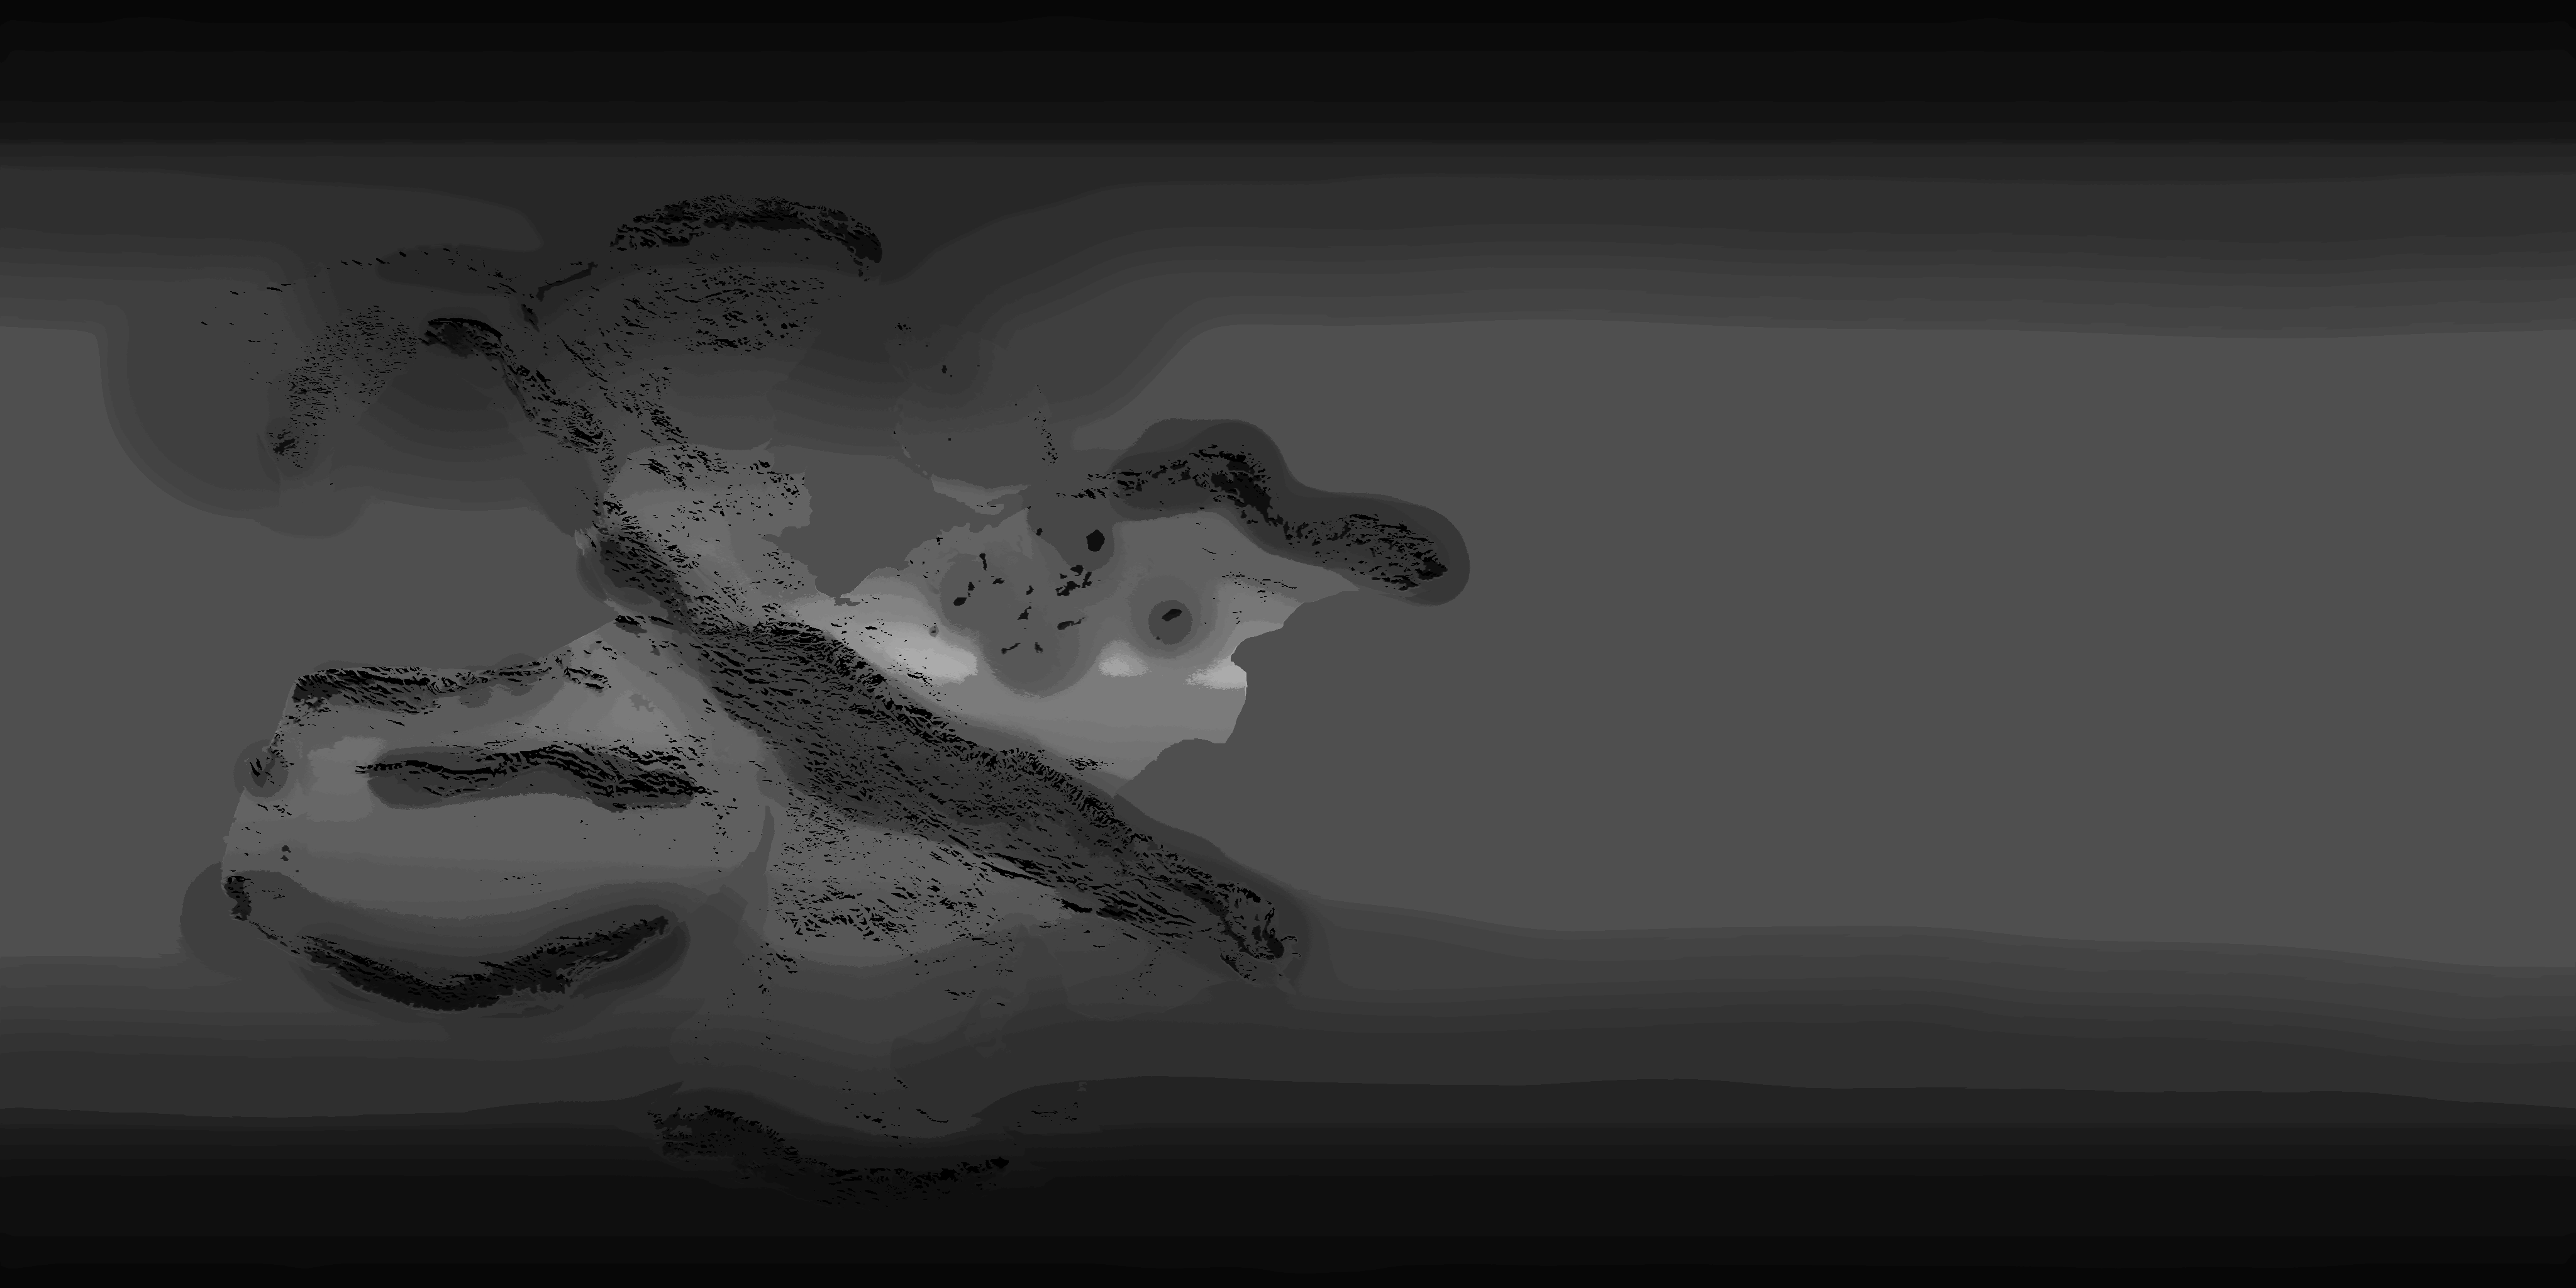

In [117]:
imMap